In [1]:
from __future__ import print_function
import collections
import pickle
import re
import random
import sys
import os 
import time

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.fasttext import FastText
from gensim.models import word2vec

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support
from sklearn import svm

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import cumsum

import tensorflow as tf
import keras
from keras import backend as K
# from tensorflow import keras as K
from keras import initializers
from keras.models import Sequential,Model,load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Add,TimeDistributed, Bidirectional,SpatialDropout1D, \
    Concatenate, concatenate, multiply, Lambda, dot, Layer
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2, l1_l2
from keras.constraints import maxnorm
from keras import callbacks
from keras.utils import generic_utils,plot_model
from keras.optimizers import Adadelta,Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
# from keras.engine.topology import Layer


import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

import sys
import re
import os
from pathlib import Path
from collections import namedtuple
import numpy as np
import pandas as pd
import pickle
import gensim.downloader as gensimapi
from collections import Counter, defaultdict
import ast

Using TensorFlow backend.


In [2]:
!ls

 Backup
'Cross Lingual Aspect Based Sentiment Analysis- Part 1.ipynb'
'Cross Lingual Aspect Based Sentiment Analysis- Part 2.ipynb'
 Keras_ML_models.ipynb
 Keras_sequential_models_3_classess.ipynb
 Keras_sequential_models.ipynb
'Multilingual  semeval  dataset creation.ipynb'
 results
'Tatoeba Similarity Search.ipynb'
 Twitter_Data.ipynb
 utils


In [3]:
# data_folder = "../../../corpus/new/preprocess_from_isuru/"
# lankadeepa_data_path = data_folder + 'lankadeepa_tagged_comments.csv'
# gossip_lanka_data_path = data_folder + 'gossip_lanka_tagged_comments.csv'

# lankadeepa_data = pd.read_csv(lankadeepa_data_path)[:9059]
# gossipLanka_data = pd.read_csv(gossip_lanka_data_path)
# gossipLanka_data = gossipLanka_data.drop(columns=['Unnamed: 3'])

# sinhala_data = pd.concat([lankadeepa_data,gossipLanka_data], ignore_index=True)
# sinhala_data.to_csv("../data/sinhala_comments.csv")

In [4]:
train_aspects_ungrp = pd.read_csv('../data/Train_english_restaurants_ungrp.csv')
val_aspects_ungrp2 = pd.read_csv('../data/Valid_english_restaurants_ungrp.csv')
du_aspects_ungrp2  = pd.read_csv('../data/Dutch_restaurants_ungrp.csv')
sp_aspects_ungrp2  = pd.read_csv('../data/Spanish_english_restaurants_ungrp.csv')

sinhala_comments  = pd.read_csv('../data/sinhala_comments.csv')


In [5]:
sinhala_comments = sinhala_comments.loc[sinhala_comments['label'].isin([2, 3, 4,5])]

In [6]:
(unique, counts) = np.unique(sinhala_comments["label"].values, return_counts = True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   2 7665]
 [   3 2403]
 [   4 3080]
 [   5 1911]]


In [7]:
train_aspects_ungrp[['text']].to_csv('../data/processed/en_resturant.csv' , header = None , index = None , mode = 'w')
val_aspects_ungrp2[['text']].to_csv('../data/processed/en_val.csv' , header = None , index = None , mode = 'w')
du_aspects_ungrp2[['text']].to_csv('../data/processed/nl_resturant.csv' , header = None , index = None , mode = 'w')
sp_aspects_ungrp2[['text']].to_csv('../data/processed/es_resturant.csv' , header = None , index = None , mode = 'w')

sinhala_comments[['comment']].to_csv('../data/processed/sinhala_comments.csv' , header = None , index = None , mode = 'w')


In [8]:
LASER_PATH = "/home/lahiru/Projects/FYP/LASER/LASER"
sys.path.insert(0, LASER_PATH + '/source/lib')
sys.path.insert(1, LASER_PATH + '/source')

DATA_PATH = Path("../data/processed/")
CACHE_PATH = Path("../cache2/")
CACHE_PATH.mkdir(exist_ok=True)
MODEL_PATH = Path(LASER_PATH + "/models")

os.environ["LASER"] = LASER_PATH 
SPACE_NORMALIZER = re.compile("\s+")
Batch = namedtuple('Batch', 'srcs tokens lengths')

In [9]:
from indexing import IndexLoad, IndexTextOpen, IndexTextQuery, IndexSearchKNN, IndexCreate, IndexSearchMultiple
from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply

In [10]:
encoder = SentenceEncoder(
    str(MODEL_PATH / "bilstm.93langs.2018-12-26.pt"),
    max_sentences=None,
    max_tokens=10000,
    cpu=False)
#original : cpu = False

bpe_codes = str(MODEL_PATH / "93langs.fcodes")

for lang in ("en" ,"nl", 'es'): 
    Token(
        str(DATA_PATH / f"{lang}_resturant.csv"), ##english_resturant.txt
        str(CACHE_PATH / f"{lang}_resturant.csv"),
        lang=lang,
        romanize=False,
        lower_case=True, gzip=False,
        verbose=True)
    BPEfastApply(
        str(CACHE_PATH / f"{lang}_resturant.csv"),
        str(CACHE_PATH / f"{lang}_resturant.bpe"),
        bpe_codes,
        verbose=True, over_write=True)
    EncodeFile(
        encoder,
        str(CACHE_PATH / f"{lang}_resturant.bpe"),
        str(CACHE_PATH / f"{lang}_resturant.enc"),
        verbose=True, over_write=True)    
    
    
Token(
    str(DATA_PATH / f"en_val.csv"), ##english_resturant.txt
    str(CACHE_PATH / f"en_val.csv"),
    lang=lang,
    romanize=False,
    lower_case=True, gzip=False,
    verbose=True)
BPEfastApply(
    str(CACHE_PATH / f"en_val.csv"),
    str(CACHE_PATH / f"en_val.bpe"),
    bpe_codes,
    verbose=True, over_write=True)
EncodeFile(
    encoder,
    str(CACHE_PATH / f"en_val.bpe"),
    str(CACHE_PATH / f"en_val.enc"),
    verbose=True, over_write=True)    

 - Tokenizer: en_resturant.csv exists already
 - Tokenizer: nl_resturant.csv exists already
 - Tokenizer: es_resturant.csv exists already
 - Tokenizer: en_val.csv exists already


In [11]:
Token(
    str(DATA_PATH / f"sinhala_comments.csv"), ##english_resturant.txt
    str(CACHE_PATH / f"sinhala_comments.csv"),
    lang="sin",
    romanize=False,
    lower_case=True, gzip=False,
    verbose=True)
BPEfastApply(
    str(CACHE_PATH / f"sinhala_comments.csv"),
    str(CACHE_PATH / f"sinhala_comments.bpe"),
    bpe_codes,
    verbose=True, over_write=True)
EncodeFile(
    encoder,
    str(CACHE_PATH / f"sinhala_comments.bpe"),
    str(CACHE_PATH / f"sinhala_comments.enc"),
    verbose=True, over_write=True)  

 - Tokenizer: sinhala_comments.csv exists already


In [12]:
LASER_PATH = "/home/lahiru/Projects/FYP/LASER/LASER"
sys.path.insert(0, LASER_PATH + '/source/lib')
sys.path.insert(1, LASER_PATH + '/source')

DATA_PATH = Path("../data/processed/")
CACHE_PATH = Path("../cache2/")
CACHE_PATH.mkdir(exist_ok=True)
MODEL_PATH = Path(LASER_PATH + "/models")

os.environ["LASER"] = LASER_PATH 
SPACE_NORMALIZER = re.compile("\s+")
Batch = namedtuple('Batch', 'srcs tokens lengths')

In [13]:
train_en, index_tr_en = IndexCreate(
    str(CACHE_PATH / "en_resturant.enc"), 'FlatL2', verbose=True, save_index=False)
val_en, index_val_en = IndexCreate(
    str(CACHE_PATH / "en_val.enc"), 'FlatL2', verbose=True, save_index=False)

data_du, index_du = IndexCreate(
    str(CACHE_PATH / "nl_resturant.enc"), 'FlatL2', verbose=True, save_index=False)
data_spanish, index_spanish = IndexCreate(
    str(CACHE_PATH / "es_resturant.enc"), 'FlatL2', verbose=True, save_index=False)

data_sinhala, index_sinhala = IndexCreate(
    str(CACHE_PATH / "sinhala_comments.enc"), 'FlatL2', verbose=True, save_index=False)

 - embedding: ../cache2/en_resturant.enc 1656 examples of dim 1024
 - creating FAISS index
 - embedding: ../cache2/en_val.enc 283 examples of dim 1024
 - creating FAISS index
 - embedding: ../cache2/nl_resturant.enc 960 examples of dim 1024
 - creating FAISS index
 - embedding: ../cache2/es_resturant.enc 1416 examples of dim 1024
 - creating FAISS index
 - embedding: ../cache2/sinhala_comments.enc 15059 examples of dim 1024
 - creating FAISS index


In [14]:
def change_target(x):
    if x=='positive':
        return 2
    elif x =='negative':
        return 1
    else:
        return 0 
    
def change_target_sinala(x):
    if x== 4:
        return 2
    elif x == 2:
        return 1
    elif x == 3:
        return 0 
    else:
        return 3

train_aspects_ungrp['polarities'] = train_aspects_ungrp['polarities'].apply(lambda x: change_target(x))
val_aspects_ungrp2['polarities'] = val_aspects_ungrp2['polarities'].apply(lambda x: change_target(x))
sp_aspects_ungrp2['polarities'] = sp_aspects_ungrp2['polarities'].apply(lambda x: change_target(x))
du_aspects_ungrp2['polarities'] = du_aspects_ungrp2['polarities'].apply(lambda x: change_target(x))

sinhala_comments['label'] = sinhala_comments['label'].apply(lambda x: change_target_sinala(x))

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
tr_eng =  train_aspects_ungrp['polarities'].values
val_eng =val_aspects_ungrp2['polarities'].values  
y_du  = du_aspects_ungrp2['polarities'].values
y_spainish  = sp_aspects_ungrp2['polarities'].values

y_sinhala  = sinhala_comments['label'].values
tr_eng.shape , val_eng.shape , y_du.shape , y_spainish.shape, y_sinhala.shape

((1656,), (283,), (960,), (1416,), (15059,))

In [16]:
(unique, counts) = np.unique(y_sinhala, return_counts = True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 2403]
 [   1 7665]
 [   2 3080]
 [   3 1911]]


In [17]:
tr_eng = pd.get_dummies(tr_eng).values
val_eng = pd.get_dummies(val_eng).values
y_du = pd.get_dummies(y_du).values
y_spainish = pd.get_dummies(y_spainish).values
y_sinhala = pd.get_dummies(y_sinhala).values

In [18]:
y_sinhala[0]

array([0, 0, 1, 0], dtype=uint8)

In [19]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(train_en)
train_std = std_scale.transform(train_en) 
val_std = std_scale.transform(val_en)
dutch_std = std_scale.transform(data_du)
spanish_std = std_scale.transform(data_spanish)
sinhala_std = std_scale.transform(data_sinhala)

In [20]:
train_std.shape

(1656, 1024)

In [21]:
time_steps = 64
features = int(len(train_std[0]))//64

In [22]:
train_std = train_std.reshape(len(train_std), time_steps, features)
sinhala_std = sinhala_std.reshape(len(sinhala_std), time_steps, features)

In [24]:
train_std.shape

(1656, 64, 16)

In [25]:
def RNN_model():
    main_input = Input(shape=(time_steps,features ), dtype='float', name='main_input')
#     embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE
#               , input_length=MAX_LEN,
#               name='embedding' ,trainable=False)(main_input)

#     embedding = Dropout(DROPOUT_VALUE_1)(main_input)

    x = RNN(HIDDEN_DIMS)(main_input)

    x = Dense(HIDDEN_DIMS, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(DROPOUT_VALUE_2, name='drop')(x)

    output = Dense(4, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer=Adadelta(lr=0.95, epsilon=1e-06),
              metrics=["accuracy",
                       keras.metrics.Precision(),
                        keras.metrics.Recall(),
                       f1])
    
    print(model.summary())
    return model

# def simple_model():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Dense(512))
#     model.add(tf.keras.layers.Dense(256))
#     model.add(tf.keras.layers.Dense(3))
#     model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=["accuracy"])
#     # This builds the model for the first time:
    
#     return model

# def simple_model2():
    
#     model = Sequential()
#     model.add(LSTM(32, input_shape=(1024, 1024)))
#     model.add(Dense(3))
#     print(model.summary())
#     model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=["accuracy"])
#     return model

    


In [26]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
def Train_Model(model,X_train, y_train, val_data=None , cross_validation = False):
    print('Training and Testing...')
    es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=5)
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_f1', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint,es]
    
    if (cross_validation):
        callbacks_list = [es]
        his = model.fit(X_train, y_train, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    else:
        his = model.fit(X_train, y_train,validation_data = val_data , epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
        #his = model.fit(X_train, y_train,validation_data = val_data , epochs=NB_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
    return model,his

In [44]:
MAX_FEATURES = 300
VERBOSITY = 1
VALIDATION_SPLIT = 0.1
NB_EPOCHS = 15
FOLDS = 10
EMBEDDING_SIZE = 300

BATCH_SIZE = 32 # 64, 128
NB_FILTERS = 200 #200
FILTER_LENGTH = 4 # test with 2,3,4,5
# HIDDEN_DIMS = NB_FILTERS * 2
HIDDEN_DIMS = 32
MAX_LEN = 210 #test with other values(only this value work for now)
DROPOUT_VALUE_1 = 0.5 #0.8 #0.3
DROPOUT_VALUE_2 = 0.5
L2_REG= 0.01

RNN = LSTM

model_save_path = "../trained_models/RNN1.hdf5"

In [37]:
model = RNN_model()

Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None


/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


# Holdout

In [36]:
X_train, X_test, y_train, y_test = train_test_split(sinhala_std, y_sinhala, test_size=VALIDATION_SPLIT, random_state=0)

In [38]:
train_model,train_his = Train_Model(model,X_train, y_train,val_data = (X_test, y_test), cross_validation = False)

Training and Testing...
Train on 13553 samples, validate on 1506 samples
Epoch 1/20
13553/13553 [==============================] - 13s 960us/step - loss: 1.1484 - accuracy: 0.5412 - precision_2: 0.6055 - recall_2: 0.3103 - f1: 0.4007 - val_loss: 1.0585 - val_accuracy: 0.5704 - val_precision_2: 0.6330 - val_recall_2: 0.4124 - val_f1: 0.5004
Epoch 2/20
13553/13553 [==============================] - 13s 927us/step - loss: 1.0722 - accuracy: 0.5742 - precision_2: 0.6401 - recall_2: 0.4098 - f1: 0.4968 - val_loss: 1.0336 - val_accuracy: 0.5717 - val_precision_2: 0.6383 - val_recall_2: 0.4489 - val_f1: 0.5346
Epoch 3/20
13553/13553 [==============================] - 13s 930us/step - loss: 1.0374 - accuracy: 0.5878 - precision_2: 0.6592 - recall_2: 0.4445 - f1: 0.5279 - val_loss: 1.0052 - val_accuracy: 0.5916 - val_precision_2: 0.6597 - val_recall_2: 0.4635 - val_f1: 0.5515
Epoch 4/20
13553/13553 [==============================] - 13s 931us/step - loss: 1.0144 - accuracy: 0.5996 - precision_2

In [39]:
train_his.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'val_f1', 'loss', 'accuracy', 'precision_2', 'recall_2', 'f1'])

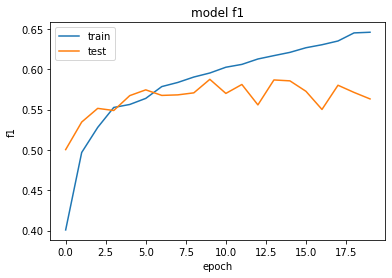

In [40]:
plt.plot(train_his.history['f1'])
plt.plot(train_his.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
scores = train_model.evaluate(X_test, y_test, verbose=1)

1506/1506 [==============================] - 0s 263us/step


In [43]:
print(f"""Evaluation Scores:
 {train_model.metrics_names[0]} of {scores[0]}; 
 {train_model.metrics_names[1]} of {scores[1]} ;
 {train_model.metrics_names[2]} of {scores[2]} ;
 {train_model.metrics_names[3]} of {scores[3]} ;
 {train_model.metrics_names[4]} of {scores[4]} ;
 """)

Evaluation Scores:
 loss of 1.1431685179115767; 
 accuracy of 0.5949535369873047 ;
 precision_2 of 0.6406117081642151 ;
 recall_2 of 0.5006639957427979 ;
 f1 of 0.5632489323616028 ;
 


# Cross Validation

In [45]:
def Do_Cross_Validation(X,y):

  # Define per-fold score containers
  loss_per_fold = []
  acc_per_fold = []
  precision_per_fold = []
  recall_per_fold = []
  f1_per_fold = []
  

  kfold = KFold(n_splits=FOLDS, shuffle=True)

  fold_no = 1
  inputs = X
  targets = y
  for train, test in kfold.split(inputs, targets):

    model = RNN_model()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model, his = Train_Model(model,inputs[train], targets[train], cross_validation=True)
 
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    print(f"""Score for fold {fold_no}:
     {model.metrics_names[0]} of {scores[0]}; 
     {model.metrics_names[1]} of {scores[1]*100}% ;
     {model.metrics_names[2]} of {scores[2]*100}% ;
     {model.metrics_names[3]} of {scores[3]*100}% ;
     {model.metrics_names[4]} of {scores[4]*100}% ;
     """)
    
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    f1_per_fold.append(scores[4])

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f"""> Fold {i+1} - 
    Loss: {loss_per_fold[i]} - 
    Accuracy: {acc_per_fold[i]}% - 
    Precesion: {precision_per_fold[i]}% - 
    Recall: {recall_per_fold[i]}% - 
    F1: {f1_per_fold[i]}%
    """)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Precision: {np.mean(precision_per_fold)}')
  print(f'> Recall: {np.mean(recall_per_fold)}')
  print(f'> F1: {np.mean(f1_per_fold)}')
  print('------------------------------------------------------------------------')

In [46]:
Do_Cross_Validation(sinhala_std, y_sinhala)

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 1 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 2 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 3 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 4 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 5 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 6 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 7 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 8 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 9 ...
Training and Testin

/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", name="output", kernel_initializer="he_normal")`
/home/lahiru/anaconda3/envs/LASER-tf-1/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 16)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                6272      
_________________________________________________________________
mlp (Dense)                  (None, 32)                1056      
_________________________________________________________________
drop (Dropout)               (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 4)                 132       
Total params: 7,460
Trainable params: 7,460
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Training for fold 10 ...
Training and Testi